# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" />

> TL;DR: _Julia looks and feels a lot like Python, only much faster. It's dynamic, expressive, extensible, with batteries included, in particular for Data Science_.

This notebook is titled **Estimating the quarantine control parameter of COVID-19**.

## Running on Google Colab
### (Courtesy Julia Community for running Julia on Colab)
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.4.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system (if you ever ask for help or file an issue about Julia, you should always provide this information).

In [1]:
versioninfo()

Julia Version 1.4.2
Commit 44fa15b150* (2020-05-23 18:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, goldmont)


# Estimating Quatantine Control Parameter

Let's upload the cleaned data file to COLAB.

In [2]:
]add MAT

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Project.toml`
  [23992714] + MAT v0.8.1
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Manifest.toml`
 [no changes]


In [17]:
using MAT

data_file = "Rise_China_Track.mat"
data = matread(data_file)

Dict{String,Any} with 4 entries:
  "China_Dead_All"      => [17.0 24.0 … 4638.0 4638.0]
  "China_Time"          => [1.0; 2.0; … ; 129.0; 130.0]
  "China_Infected_All"  => [444.0 549.0 … 84128.0 84146.0]
  "China_Recovered_All" => [28.0 31.0 … 79386.0 79389.0]

In [18]:
headers = ["China_Dead_All", "China_Time", "China_Infected_All", "China_Recovered_All"]

Dead = data[headers[1]]
Time = data[headers[2]]
Infected = data[headers[3]]
Recovered = data[headers[4]]

# Confirming that the data is in okay shape
@assert length(Dead) == length(Time) == length(Infected) == length(Recovered)

data_length = length(Dead)

130

We have an array of infected, dead, quarantined and recovered people and the indexing represents a time point. So, data[0] means the values at t_0.

We are going to use the QSIR model where 
- Q(t) represents a time varying parameter called quarantine control encoding information about the various policies and measures such as social distancing etc.
- S(t) represents the suceptible population.
- I(t) represents the infected population.
- R(t) represents the recovered population. This includes all the population which cannot spread coronavirus anymore. So, R(t) = Recovered(t) + Dead(t)


The model is different from the classical SIR, where β and γ are fixed constants, and therefore, have no information with respect to time.
In QSIR, we have a quarantined population T(t) defined as:

T(t) = Q(t) * I(t)

Our reproduction number changes from 

R_eff = β/γ 

To 

C_eff = (β)/(γ+δ+Q(t)). 

It functions the same, which means if C_eff < 1, our rate of infection is less than rate of recovery and C_eff > 1, our rate of infection is higher than rate of recovery.

Our differential equations are given in the ODE function.

In [19]:
Infected = Infected - Recovered - Dead

1×130 Array{Float64,2}:
 399.0  494.0  689.0  964.0  1302.0  …  101.0  97.0  103.0  104.0  119.0

## ODE Problem
A mixed first principles based approach and data driven modelling.
Using Julia tools, DifferentialEquation.jl and Flux.jl

Let's add them to our arsenal.

In [6]:
]add Flux DifferentialEquations

  Resolving package versions...
  Installed UnPack ───────────────── v1.0.2
  Installed PrettyPrint ──────────── v0.2.0
  Installed OffsetArrays ─────────── v1.1.3
  Installed NLSolversBase ────────── v7.7.0
  Installed Flux ─────────────────── v0.11.1
  Installed Latexify ─────────────── v0.13.5
  Installed LightGraphs ──────────── v1.3.3
  Installed DifferentialEquations ── v6.15.0
  Installed FunctionWrappers ─────── v1.1.1
  Installed DiffEqNoiseProcess ───── v5.3.0
  Installed Unitful ──────────────── v1.4.0
  Installed BandedMatrices ───────── v0.15.15
  Installed Inflate ──────────────── v0.1.2
  Installed Formatting ───────────── v0.4.1
  Installed CUDA ─────────────────── v1.3.3
  Installed SIMDPirates ──────────── v0.8.24
  Installed RecursiveFactorization ─ v0.1.4
  Installed SafeTestsets ─────────── v0.0.1
  Installed ExponentialUtilities ─── v1.8.0
  Installed FastClosures ─────────── v0.3.2
  Installed ModelingToolkit ──────── v3.19.0
  Installed VectorizationBase ────── 

  [b14d175d] + JuliaVariables v0.2.3
  [e5e0dc1b] + Juno v0.8.3
  [929cbde3] + LLVM v2.0.0
  [b964fa9f] + LaTeXStrings v1.1.0
  [2ee39098] + LabelledArrays v1.3.0
  [23fbe1c1] + Latexify v0.13.5
  [1d6d02ad] + LeftChildRightSiblingTrees v0.1.2
  [093fc24a] + LightGraphs v1.3.3
  [d3d80556] + LineSearches v7.1.0
  [e6f89c97] + LoggingExtras v0.4.2
  [bdcacae8] + LoopVectorization v0.8.25
  [d00139f3] + METIS_jll v5.1.0+4
  [d8e11817] + MLStyle v0.4.6
  [e89f7d12] + Media v0.5.0
  [961ee093] + ModelingToolkit v3.19.0
  [46d2c3a1] + MuladdMacro v0.2.2
  [f9640e96] + MultiScaleArrays v1.8.1
  [d41bc354] + NLSolversBase v7.7.0
  [2774e3e8] + NLsolve v4.4.1
  [872c559c] + NNlib v0.7.4
  [71a1bf82] + NameResolution v0.1.5
  [6fe1bfb0] + OffsetArrays v1.1.3
  [4536629a] + OpenBLAS_jll v0.3.10+0
  [efe28fd5] + OpenSpecFun_jll v0.5.3+3
  [1dea7af3] + OrdinaryDiffEq v5.42.3
  [90014a1f] + PDMats v0.10.0
  [65888b18] + ParameterizedFunctions v5.5.0
  [d96e819e] + Parameters v0.12.1
  [e409e4f3] + 

In [7]:
using Flux
using DifferentialEquations

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1260


Let's define our architecture as a simple 2 layer deep model where hidden layer consists of 10 nodes.

Since our input is of size 3, and our output is of size 1.

Input = S, I, R parameters
Output = Q parameter

3 x 10, 10 x 1, RELU

In [20]:
arch = Chain(Dense(3, 10, relu), Dense(10, 1))
p1, rest = Flux.destructure(arch)

# Parameters from the SIR: β, γ and δ
p2 = Float64[0.15, 0.01, 0.012]

# Combine both sets of parameters
p3 = [p1; p2]

# Flux Wrapper
params = Flux.params(p3)

length(p3) # We have 54 parameters that we can tune.

54

In [21]:
# Population of China which is 1.393 billion
N = 1393000000.0

function QSIR(du, u, p, t)
  β = abs(p[52])
  γ = abs(p[53])
  δ = abs(p[54])

  u_t = [u[1]; u[2]; u[3]]
  NN = abs(rest(p[1:51])(u_t)[1]) # Reconstruct our neural network

  du[1] = -β * u[1] * u[2] / N
  du[2] = (β * u[1] * u[2] / N) - (γ * u[2] + u[2] * NN / N)
  du[3] = γ * u[2] + δ * u[4]
  du[4] = NN * u[2] / N - δ * u[4]
end

u0 = Float64[N, Infected[1], (Dead + Recovered)[1], 10]
tspan = (0.0, data_length)

prob = ODEProblem(QSIR, u0, tspan, p3)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 130.0)
u0: [1.393e9, 399.0, 45.0, 10.0]

In [22]:
t = range(tspan[1], tspan[2], length=data_length)

solver = Tsit5()

Tsit5()

In [11]:
]add DiffEqFlux

  Resolving package versions...
  Installed Tracker ──────────────── v0.2.11
  Installed DiffEqSensitivity ────── v6.31.5
  Installed CPUTime ──────────────── v1.0.0
  Installed MKL_jll ──────────────── v2020.2.254+0
  Installed DiffEqFlux ───────────── v1.21.0
  Installed QuasiMonteCarlo ──────── v0.2.0
  Installed FFTW ─────────────────── v1.2.4
  Installed DistributionsAD ──────── v0.6.7
  Installed ReverseDiff ──────────── v1.4.2
  Installed LatinHypercubeSampling ─ v1.6.4
  Installed SpatialIndexing ──────── v0.1.2
  Installed Sobol ────────────────── v1.4.0
  Installed BlackBoxOptim ────────── v0.5.0
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Project.toml`
  [aae7a2af] + DiffEqFlux v1.21.0
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Manifest.toml`
  [a134a8b2] + BlackBoxOptim v0.5.0
  [a9c8d775] + CPUTime v1.0.0
  [aae7a2af] + DiffEqFlux v1.21.0
  [41bf760c] + DiffEqSensitivity v6.31.5
  [ced4e

In [23]:
using DiffEqFlux

function predict()
  Array(concrete_solve(prob, solver, u0, p3, saveat=t))
end

# Impact of nonpharmaceutical interventions (npis) to reduce covid-19 
# mortality and healthcare demand. Imperial College London
function calc_loss()
  prediction = predict()
  sum(abs2, log.(abs.(Infected[1:end])) .- log.(abs.(prediction[2, :] .+ prediction[4, :]))) + (sum(abs2, log.(abs.(Recovered[1:end] .+ Dead[1:end])) .- log.(abs.(prediction[3, :]))))
end

calc_loss (generic function with 1 method)

In [24]:
sol = predict()

┌ Warning: `concrete_solve(prob::DiffEqBase.DEProblem, alg::Union{DiffEqBase.DEAlgorithm, Nothing}, u0 = prob.u0, p = prob.p, args...; kwargs...)` is deprecated, use `solve(prob, alg, args...; u0 = u0, p = p, kwargs...)` instead.
│   caller = ip:0x0
└ @ Core :-1


4×130 Array{Float64,2}:
   1.393e9    1.393e9    1.393e9  …     1.393e9     1.393e9     1.393e9
 399.0      395.904    392.832        148.377     147.226     146.084
  45.0       49.4823    54.6363      3006.17     3033.8      3061.36
  10.0       68.6932   126.225       2163.3      2159.17     2154.92

In [25]:
]add Plots

  Resolving package versions...
  Installed Plots ─ v1.5.9
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Project.toml`
  [91a5bcdd] + Plots v1.5.9
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Manifest.toml`
  [91a5bcdd] ↑ Plots v1.5.6 ⇒ v1.5.9
   Building Plots → `~/.julia/packages/Plots/shY1Z/deps/build.log`


In [26]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [68]:
Losses = []
βs = []
γs = []
P3 = []

callback = function()
    loss = calc_loss()    
    global Losses = append!(Losses, loss)
    global βs = append!(βs, p3[52])
    global γs = append!(γs, p3[53])
    global P3 = append!(P3, p3)
end

#37 (generic function with 1 method)

In [96]:
anime = Animation()
iterator = Iterators.repeated((), 100)
opt = ADAM(0.01)

callback();

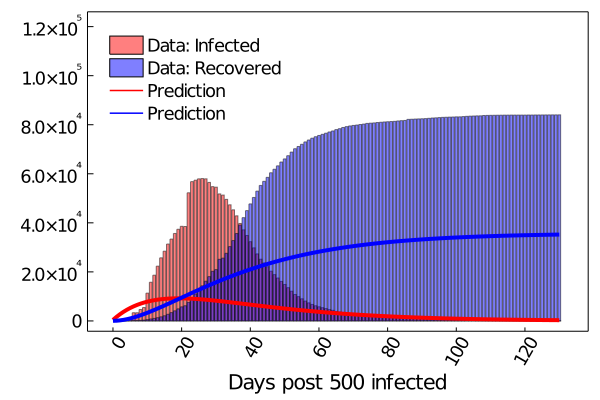

264.2497079544408

In [ ]:
counter = 0
nE = 130

for i = 1:nE
    Flux.train!(calc_loss, params, iterator, opt, cb = callback)
    
    plt = bar(Infected',alpha=0.5,label="Data: Infected",color="red")
    bar!(Recovered' + Dead',alpha=0.5,xrotation=60,label="Data: Recovered", color="blue")
    
    loss = findmin(Losses)
    
    idx = loss[2]
    idx_start = (idx - 1) * 54 + 1
    idx_end = idx * 54

    p3_loop = P3[idx_start: idx_end]

    prediction = Array(concrete_solve(prob, Tsit5(), u0, p3_loop, saveat=t))

    plot!(plt, t, prediction[2, :] .+ prediction[4, :] , xaxis = "Days post 500 infected", label = "Prediction", legend = :topright, framestyle = :box, grid = :off, color = :red, linewidth  = 4, foreground_color_legend = nothing, background_color_legend = nothing, yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)
    plot!(plt, t, prediction[3, :], ylims = (-0.05*maximum(Recovered + Dead),1.5*maximum(Recovered + Dead)), xaxis = "Days post 500 infected", label = "Prediction ", legend = :topleft, framestyle = :box, grid = :off, color = :blue, linewidth  = 4, foreground_color_legend = nothing, background_color_legend = nothing,  yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)
    
    IJulia.clear_output(true)
    display(plt)
    display(loss[1])
end


In [93]:
L = findmin(Losses)

idx = L[2]
idx_start = (idx - 1) * 54 + 1
idx_end = idx * 54

p3_trained = P3[idx_start: idx_end]

54-element Array{Any,1}:
 -0.4017677307128906
 -0.04429182410240173
 -0.09864204376935959
  0.7826795435602271
  0.7079685308720463
 -0.26628854870796204
 -0.29390260577201843
  0.7459165071063749
 -0.24297811090946198
 -0.0029739816694920006
  0.38196030259132385
  0.598415732383728
 -0.3138350546360016
  ⋮
  0.1930677741765976
  2.568990818419018
  2.1036354392475074
  0.6548838019371033
 -0.039502110332250595
  2.544715549815674
 -0.5213858485221863
 -0.15971814152467953
  0.4068375729980408
  5.396277334307077
  0.00015645958645648143
  0.0739281642078002

In [94]:
prediction = Array(concrete_solve(prob, Tsit5(), u0, p3_trained, saveat=t))

4×130 Array{Float64,2}:
   1.393e9     1.393e9     1.393e9  …      1.39293e9      1.39293e9
 399.0       398.338     397.601           0.0580128      0.0528084
  45.0       124.615     354.08        74869.1        74875.3
  10.0      2099.07     4034.59           87.3942        81.4149

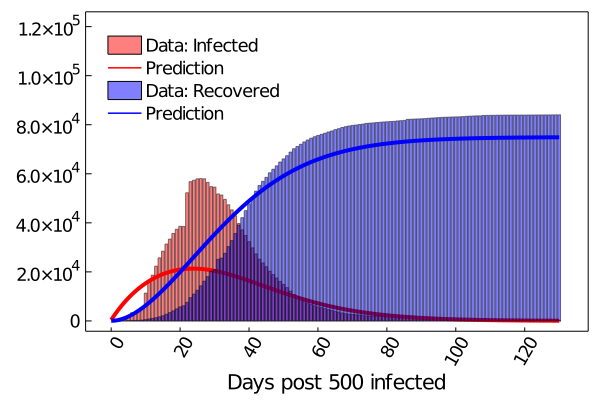

In [95]:
bar(Infected',alpha=0.5,label="Data: Infected",color="red")
plot!(t, prediction[2, :] .+ prediction[4, :] , xaxis = "Days post 500 infected", label = "Prediction", legend = :topright, framestyle = :box, grid = :off, color = :red, linewidth  = 4, foreground_color_legend = nothing, background_color_legend = nothing, yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)
bar!(Recovered' + Dead',alpha=0.5,xrotation=60,label="Data: Recovered", color="blue")
plot!(t, prediction[3, :], ylims = (-0.05*maximum(Recovered + Dead),1.5*maximum(Recovered + Dead)), xaxis = "Days post 500 infected", label = "Prediction ", legend = :topleft, framestyle = :box, grid = :off, color = :blue, linewidth  = 4, foreground_color_legend = nothing, background_color_legend = nothing,  yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)